# ODS – Etapa 2 (Clasificación de texto)
El objetivo de este trabajo es clasificar opiniones ciudadanas en relación con los Objetivos de Desarrollo Sostenible (ODS) 1, 3 y 4 mediante modelos de aprendizaje supervisado.  
- **ODS 1:** Fin de la pobreza  
- **ODS 3:** Salud y bienestar  
- **ODS 4:** Educación de calidad  


Estructura:
1) Entendimiento de los datos
2) Procesamiento de datos
3) Modelos (vistos y no vistos en clase)
4) Ajuste de hiperparámetros
5) Modelo Final
6) Interpretación de resultados
7) Exportación de predicciones 

## 1. Entendimiento de Datos

### 1.1 Imports y configuración

En esta sección se cargan las librerías necesarias para el proyecto.  
- **pandas, numpy y matplotlib**: herramientas base para manipulación de datos y visualización.  
- **scikit-learn**: librería principal para machine learning, desde donde se importan módulos para:
  - **Preprocesamiento**: TfidfVectorizer para convertir textos en vectores numéricos.  
  - **Modelado**: SVC  
  - **Evaluación**: train_test_split, GridSearchCV, StratifiedKFold, métricas y visualización de la matriz de confusión.  
  - **Feature selection**: chi2 para selección estadística de variables.  
- **joblib**: para exportar el modelo final entrenado.  

Además, se establecen parámetros de estilo para las gráficas y se fija una semilla aleatoria `RANDOM_STATE = 42` con el fin de garantizar reproducibilidad de los resultados.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import chi2
from joblib import dump

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Buena practica para reproducibilidad


### 1.2 Carga de datos

Los datos provienen de archivos en formato XLS:

Cada registro tiene dos columnas principales:  
- **textos**: la opinión ciudadana en lenguaje natural.  
- **labels**: la etiqueta correspondiente al ODS asociado (1 = Fin de la pobreza, 3 = Salud y bienestar, 4 = Educación de calidad).

Se realiza:  
1. Lectura de los archivos Excel.  
2. Selección de las columnas relevantes. 
3. Se dejan los datos de la etapa 1 para entrenamiento, y los de la etapa 2 netamente para la validación entre el modelo de la etapa 1 y el modelo reentrenado con prompting.
4. Visualización de las primeras instancias para confirmar la correcta importación.

In [20]:
DATA_PATH_1   = "Datos_proyecto.xlsx"  
DATA_PATH_2   = "Datos_etapa 2.xlsx"  
DATA_PATH_TEST = "Datos de prueba_proyecto.xlsx"        
TEXT_COL    = "textos"                       
LABEL_COL   = "labels"

xls1 = pd.ExcelFile(DATA_PATH_1)
xls2 = pd.ExcelFile(DATA_PATH_2)
print("Hojas:", xls1.sheet_names)

df = pd.read_excel(DATA_PATH_1, sheet_name=xls1.sheet_names[0])
df_validacion = pd.read_excel(DATA_PATH_2, sheet_name=xls2.sheet_names[0])
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"textos", LABEL_COL:"labels"})
test_data= pd.read_excel(DATA_PATH_TEST)
df.head(10)

Hojas: ['Sheet1']


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
5,Los datos a nivel del sistema que no se deriva...,4
6,La principal ventaja de las evaluaciones exter...,4
7,Los pacientes pueden elegir a cualquier médico...,3
8,"De hecho, es probable que la designación de la...",4
9,"De hecho, aunque Chile y Uruguay tienen índice...",1


### 1.3 Entendimiento de los datos

En esta sección realizamos un perfilamiento rápido del dataset para validar su estructura y conocer el comportamiento básico de los textos y las etiquetas (ODS). En particular:

- **Estructura y tipos**: dimensiones del dataset, columnas y tipos de dato.
- **Longitud de textos**: cálculo del numero de palabras y caracteres por opinión; estadísticos descriptivos.
- **Distribuciones**: histogramas y boxplots para identificar sesgos y posibles outliers.
- **Etiquetas (ODS)**: conteos y proporciones por clase para detectar desbalance.

Este diagnóstico guía las decisiones de **preparación** (limpieza, normalización, vectorización) y **evaluación** (métricas y validación estratificada) en el modelado.

In [21]:
print("Dimensiones:", df.shape)
display(df.info())

Dimensiones: (2424, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


None

In [22]:
# Longitud de textos
df["len_words"] = df["textos"].astype(str).str.split().str.len()
df["len_chars"] = df["textos"].astype(str).str.len()
df[["len_words","len_chars"]].describe().T

,count,mean,std,min,25%,50%,75%,max
len_words,2424.0,107.924092,35.575349,41.0,81.0,102.0,129.00,260.0
len_chars,2424.0,683.223185,223.563695,303.0,513.0,647.0,809.25,1492.0


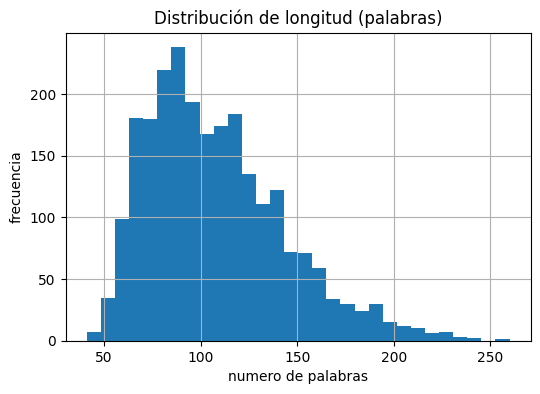

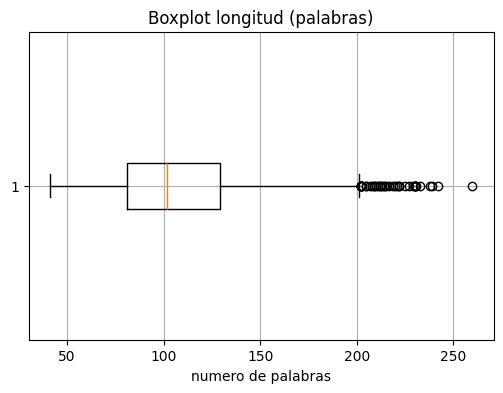

In [23]:
# Histograma longitudes (palabras)
fig, ax = plt.subplots()
ax.hist(df["len_words"], bins=30)
ax.set_title("Distribución de longitud (palabras)")
ax.set_xlabel("numero de palabras"); ax.set_ylabel("frecuencia")
plt.show()

# Boxplot para outliers
fig, ax = plt.subplots()
ax.boxplot(df["len_words"], vert=False)
ax.set_title("Boxplot longitud (palabras)")
ax.set_xlabel("numero de palabras")
plt.show()

labels
4    1025
3     894
1     505
Name: count, dtype: int64

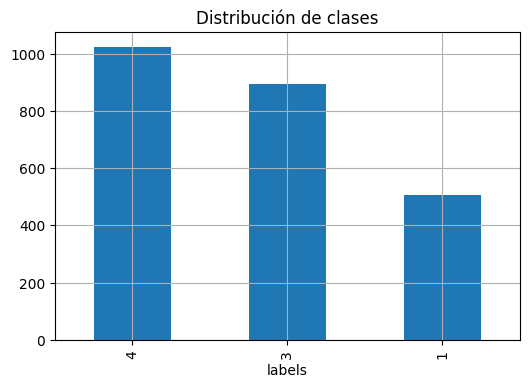

In [24]:
# Distribución de las clases
counts = df["labels"].value_counts()
counts.plot.bar(title="Distribución de clases")
counts


**Interpretacion del entendimiento de datos**

- Dataset con **2,424 registros** y **2 columnas** textos y labels, sin valores nulos.  
- Opiniones con longitud media de **108 palabras** y **683 caracteres**; se observan textos muy extensos pero no afectan el análisis inicial.  
- Distribución de etiquetas: ODS 4 = 1,025; ODS 3 = 894; ODS 1 = 505 → existe **desbalance moderado**, especialmente en ODS 1. 
- Decisiones: Hacemos prompting para nivelar las clases (esto esta en procesamiento de datos)


### 1.4 Revisión Calidad de datos

Evaluamos 4 dimensiones prácticas para texto:
1) **Completitud**: NA, vacíos, mínimos de longitud.
2) **Unicidad**: duplicados por textos y por textos+labels.
3) **Validez/Consistencia**: esquema esperado y dominio de labels: 1,3,4.
4) **Ruido/Outliers**: textos extremadamente largos/cortos y señales de ruido.

In [25]:
# 1) Completitud
print("Completitud")
na = df.isna().sum()
print("Cantidad de cols con NA:", na.sum())
empty = (df["textos"].astype(str).str.strip()=="").sum()
print("Cantidad de cols vacías:", empty)

# 2) Unicidad
print("\nUnicidad")
dup_text = df.duplicated(subset=["textos"]).sum()
print("Cantidad de textos duplicados:", dup_text)
dup_both = df.duplicated(subset=["textos","labels"]).sum()
print("Cantidad de filas duplicadas:", dup_both)

# 3) Validez / Consistencia
print("\nValidez / Consistencia")
cols_ok = set(df.columns) == {"textos","labels","len_words","len_chars"}
print("Columnas correctas en todo el DataFrame:", cols_ok)
labels_ok = set(df["labels"].unique()) <= {1,3,4}
print("Etiquetas correctas en todo el DataFrame:", labels_ok)

# 4) Ruido / Outliers
print("\nRuido / Outliers")
alpha = df["textos"].astype(str).apply(lambda s: sum(ch.isalpha() for ch in s)/max(1,len(s)))
pct_ruido = (alpha<0.6).mean()
print("Porcentaje de textos con menos del 60% de caracteres alfabéticos:", pct_ruido)
p75, p95, pmax = df["len_words"].quantile([.75, .95, 1.0])
print("Percentil 75, 95 y maximo de longitud (palabras):", p75, p95, pmax)

Completitud
Cantidad de cols con NA: 0
Cantidad de cols vacías: 0

Unicidad
Cantidad de textos duplicados: 0
Cantidad de filas duplicadas: 0

Validez / Consistencia
Columnas correctas en todo el DataFrame: True
Etiquetas correctas en todo el DataFrame: True

Ruido / Outliers
Porcentaje de textos con menos del 60% de caracteres alfabéticos: 0.0
Percentil 75, 95 y maximo de longitud (palabras): 129.0 177.0 260.0
Porcentaje de textos con menos del 60% de caracteres alfabéticos: 0.0
Percentil 75, 95 y maximo de longitud (palabras): 129.0 177.0 260.0


**Intepretación de la calidad de datos**

- **Completitud:** no se encontraron valores nulos ni textos vacíos; todos cumplen el mínimo de 3 palabras.  
- **Unicidad:** no hay duplicados ni por textos ni por textos+labels.  
- **Validez/Consistencia:** el esquema de columnas es el esperado y las etiquetas pertenecen al dominio correcto: 1, 3, 4.  
- **Ruido/Outliers:** 0% de textos con baja proporción alfabética; las longitudes muestran cola derecha con máximos de 260 palabras (esperables en opiniones extensas).  

En general, la base presenta alta calidad: completa, sin duplicados y con etiquetas válidas. Solo se documentan outliers largos, que no afectan el entrenamiento inicial.

## 2. Preparación de datos

Para entrenar modelos de clasificación de texto se realizaron tres pasos:

1. **Balanceo de etiquetas**: Se realiza la aumentación usando IA generativa.
2. **Normalización y estandarización**: limpieza de caracteres, minúsculas, tokenización, eliminación de stopwords en español y stemming.  
3. **Split de datos**: división en entrenamiento, y prueba.  
4. **Vectorización TF-IDF**: transformación de textos a representaciones numéricas considerando unigramas y bigramas, con filtros de frecuencia mínima y máxima.

### 1. Balanceo de etiquetas

**Estrategia de Augmentación de Datos con LLMs**

Para solucionar el desbalance de clases identificado en el entendimiento de datos, implementamos una estrategia de **augmentación de datos sintéticos usando modelos de lenguaje grandes (LLMs)**. Esta técnica permite generar textos artificiales que mantienen las características lingüísticas y semánticas de cada clase objetivo.

**Problemática del desbalance:**
- ODS 4 (Educación): 1,025 ejemplos (clase mayoritaria)
- ODS 3 (Salud): 894 ejemplos 
- ODS 1 (Pobreza): 505 ejemplos (clase minoritaria)

**Objetivo de balanceo:**
Nivelar todas las clases a **1,025 ejemplos** cada una, generando:
- **520 textos sintéticos** para ODS 1 (Fin de la pobreza)
- **131 textos sintéticos** para ODS 3 (Salud y bienestar)
- **0 textos adicionales** para ODS 4 (ya balanceada)

In [26]:
%pip install openai
%pip install dotenv
from dotenv import load_dotenv
load_dotenv()

# Validación de dependencias
print("\nValidación de dependencias")
import sys, site, platform, os
secret = os.getenv("OPENAI_API_KEY")
print("API Key:", "OK" if secret and len(secret)>20 else "MISSING")
print("Python exe:", sys.executable)
print("Version:", sys.version)
print("Site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())
print("OS:", platform.platform())

## Dependencias
import os
from openai import OpenAI
import pandas as pd, random

# Validación de conectividad
client = OpenAI(api_key=secret)
models = client.models.list()
print("OK SDK v1.x, modelos:", len(models.data))


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Validación de dependencias
API Key: OK
Python exe: c:\Users\yarso\AppData\Local\Programs\Python\Python311\python.exe
Version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Site-packages: ['c:\\Users\\yarso\\AppData\\Local\\Programs\\Python\\Python311', 'c:\\Users\\yarso\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages']
OS: Windows-10-10.0.26100-SP0
Note: you may need to restart the kernel to use updated packages.

Validación de dependencias
API Key: OK
Python exe: c:\Users\yarso\AppData\Local\Programs\Python\Python311\python.exe
Version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Site-packages: ['c:\\Users\\yarso\\AppData\\Local\\Programs\\Python\\Python311', 'c:\\Users\\yarso\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages']
OS: Windows-10-10.0.2610

In [27]:
# --- Augmentación de clases para balanceo ---
# Este bloque prepara el snapshot original y las semillas para cada clase.
TEXTO = "textos"
ODS = "labels"
cols = ["textos", "labels"]
df_before = df[cols].drop_duplicates().copy()

**Metodología de Generación por Lotes**

Debido a las limitaciones de tokens de los LLMs y para asegurar mayor control sobre la calidad de los datos generados, implementamos una **estrategia de generación iterativa en lotes pequeños**:

**Configuración de parámetros:**
- **Tamaño de lote:** 50 textos por iteración
- **Modelo utilizado:** GPT-4o-mini (OpenAI)
- **Temperatura:** 0.7 (balance entre creatividad y coherencia)
- **Semillas contextuales:** 8 ejemplos reales por clase para guiar la generación

**Ventajas de la generación por lotes:**
1. **Control de calidad:** Permite revisar y ajustar entre iteraciones
2. **Manejo de errores:** Evita pérdida total si falla una generación
3. **Límites de tokens:** Respeta restricciones de la API sin sobrecarga
4. **Generación en tiempo real:** Visualización del progreso durante la ejecución

**Criterios de calidad establecidos:**
- Longitud controlada: Se delimitó un rango de palabras por texto
- Formato natural: 1-2 oraciones coherentes
- Diversidad temática: rotación de contextos urbano/rural/periurbano
- Autenticidad: evita repetición de frases y copia literal de semillas

In [28]:
df["labels"].value_counts()

labels
4    1025
3     894
1     505
Name: count, dtype: int64

**Diseño de Prompts Especializados por Clase**

**Estructura del prompt para ODS 1 (Fin de la Pobreza):**

El prompt fue diseñado con una arquitectura específica para generar contenido relevante y diverso:

**Componentes del prompt:**
1. **Instrucción principal:** Cantidad exacta a generar y contexto colombiano
2. **Scope temático:** Situaciones de pobreza, empleo, vivienda, alimentación y servicios básicos
3. **Restricciones de formato:** Longitud de 12-38 palabras, 1-2 oraciones naturales
4. **Diversidad obligatoria:** Alternancia entre zonas geográficas y actores sociales
5. **Reglas de calidad:** Prevención de repetición, datos sensibles y sesgos políticos
6. **Ejemplos contextuales:** Semillas reales de la clase para guiar el estilo
7. **Formato de salida:** Estructura JSON específica con campos textos y labels

**Estrategias de diversidad implementadas:**
- **Geográfica:** urbano, rural, periurbano
- **Actores:** familias, trabajadores, líderes comunitarios
- **Enfoques:** problema, recurso, acceso, impacto
- **Consecuencias:** bienestar, inclusión, oportunidades, calidad de vida

**Controles de calidad en el prompt:**
- Prohibición de copiar semillas literalmente
- Evitar repetición de más de 5 palabras consecutivas
- Exclusión de datos personales y política partidista
- Formato JSON estricto para facilitar procesamiento automático

In [29]:
# --- Augmentación iterativa para la clase 1 (ODS 1: Fin de la pobreza) ---
import json
minoritaria = 1
total_needed = 1025 - df["labels"].value_counts()[minoritaria]
batch_size = 50
generated = 0
semillas = (
    df[df["labels"]==minoritaria]["textos"]
      .dropna()
      .astype(str)
      .sample(
          min(8, sum(df["labels"]==minoritaria)),
          random_state=42
      )
      .tolist()
)
ejemplos = "\n".join(f"- {s}" for s in semillas)
while generated < total_needed:
    current_batch = min(batch_size, total_needed - generated)
    prompt = f"""
    Genera EXACTAMENTE {current_batch} opiniones sintéticas sobre pobreza y acceso a recursos básicos en Colombia.
    Las opiniones deben reflejar situaciones de familias, comunidades, empleo, vivienda, alimentación, acceso a servicios y superación de la pobreza.
    Longitud: 12-38 palabras, 1–2 oraciones naturales. Sin listas, sin encabezados.
    Diversidad: alterna zona (urbano/rural/periurbano), actores (familias, trabajadores, líderes comunitarios), enfoques (problema, recurso, acceso, impacto) y consecuencias (bienestar, inclusión, oportunidades, calidad de vida).
    Reglas:
    - \"labels\" siempre {minoritaria}
    - No repetir >5 palabras seguidas entre textos
    - No datos personales, ni política partidista, ni salud sensible específica
    - No citar la palabra ODS ni copiar semillas
    Semillas (NO copiar literal):
    {ejemplos if 'ejemplos' in globals() and ejemplos else '- (sin semillas)'}
    Formato: SOLO un array JSON de objetos {{\"textos\": \"...\", \"labels\": {minoritaria}}}
    Si no puedes cumplir todas las reglas, devuelve [{{\"error\":\"spec_violation\"}}]
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Eres un generador de datos sintéticos."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7
)
    raw = response.choices[0].message.content
    txt = raw.strip()
    if txt.startswith("```"):
        txt = txt.strip("`")
        if "\n" in txt:
            txt = txt.split("\n", 1)[1]
    data = json.loads(txt)
    df_new_1 = pd.DataFrame(data)
    df = pd.concat([df, df_new_1[["textos", "labels"]]], ignore_index=True)
    generated += len(df_new_1)
    print(f"Generados {generated}/{total_needed} para clase 1")
print(f"Filas totales ahora: {len(df)} (tras augmentación clase 1)")
print(f"Fila generadas: {len(df)-2424}")

Generados 47/520 para clase 1
Generados 91/520 para clase 1
Generados 91/520 para clase 1
Generados 138/520 para clase 1
Generados 138/520 para clase 1
Generados 184/520 para clase 1
Generados 184/520 para clase 1
Generados 229/520 para clase 1
Generados 229/520 para clase 1
Generados 277/520 para clase 1
Generados 277/520 para clase 1
Generados 321/520 para clase 1
Generados 321/520 para clase 1
Generados 369/520 para clase 1
Generados 369/520 para clase 1
Generados 415/520 para clase 1
Generados 415/520 para clase 1
Generados 458/520 para clase 1
Generados 458/520 para clase 1
Generados 505/520 para clase 1
Generados 505/520 para clase 1
Generados 520/520 para clase 1
Filas totales ahora: 2944 (tras augmentación clase 1)
Fila generadas: 520
Generados 520/520 para clase 1
Filas totales ahora: 2944 (tras augmentación clase 1)
Fila generadas: 520


**Adaptación del Prompt para ODS 3 (Salud y Bienestar)**

**Diferenciación temática para la clase de salud:**

El prompt para ODS 3 mantiene la misma estructura metodológica pero se especializa en contenido específico de salud y bienestar:

**Elementos temáticos específicos:**
- **Servicios de salud:** acceso, disponibilidad y calidad de atención médica
- **Prevención:** programas de prevención y promoción de la salud
- **Hábitos saludables:** nutrición, ejercicio y autocuidado
- **Atención médica:** consultas, tratamientos y seguimientos
- **Salud mental:** bienestar psicológico y apoyo emocional
- **Calidad de vida:** impacto integral en el bienestar ciudadano

**Actores específicos del sector salud:**
- **Pacientes:** usuarios de servicios de salud
- **Profesionales:** médicos, enfermeras, promotores de salud
- **Familias:** cuidadores y redes de apoyo familiares

**Mantiene los mismos controles de calidad:**
- Longitud de 12-38 palabras
- Diversidad geográfica (urbano/rural/periurbano)
- Prohibición de datos sensibles específicos de salud
- Formato JSON estructurado para procesamiento automático

**Diferencia clave con ODS 1:**
Mientras ODS 1 se enfoca en aspectos socioeconómicos y de recursos básicos, ODS 3 se centra específicamente en servicios, prevención y bienestar integral de las personas.

In [31]:
# --- Augmentación iterativa para la clase 3 (ODS 3: Salud y bienestar) ---
import json
minoritaria = 3
total_needed = 1025 - df["labels"].value_counts()[minoritaria]
batch_size = 50
generated = 0
semillas = (
    df[df["labels"]==minoritaria]["textos"]
      .dropna()
      .astype(str)
      .sample(
          min(8, sum(df["labels"]==minoritaria)),
          random_state=42
      )
      .tolist()
)
ejemplos = "\n".join(f"- {s}" for s in semillas)
while generated < total_needed:
    current_batch = min(batch_size, total_needed - generated)
    prompt = f"""
    Genera EXACTAMENTE {current_batch} opiniones sintéticas sobre salud y bienestar en Colombia.
    Las opiniones deben reflejar temas de acceso a servicios de salud, prevención, hábitos saludables, atención médica, salud mental y calidad de vida.
    Longitud: 12-38 palabras, 1–2 oraciones naturales. Sin listas, sin encabezados.
    Diversidad: alterna zona (urbano/rural/periurbano), actores (pacientes, profesionales de la salud, familias), enfoques (prevención, acceso, recursos, impacto) y consecuencias (bienestar, continuidad escolar, inserción laboral, prevención).
    Reglas:
    - \"labels\" siempre {minoritaria}
    - No repetir >5 palabras seguidas entre textos
    - No datos personales, ni política partidista, ni salud sensible específica
    - No citar la palabra ODS ni copiar semillas
    Semillas (NO copiar literal):
    {ejemplos if 'ejemplos' in globals() and ejemplos else '- (sin semillas)'}
    Formato: SOLO un array JSON de objetos {{\"textos\": \"...\", \"labels\": {minoritaria}}}
    Si no puedes cumplir todas las reglas, devuelve [{{\"error\":\"spec_violation\"}}]
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Eres un generador de datos sintéticos."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7
)
    raw = response.choices[0].message.content
    txt = raw.strip()
    if txt.startswith("```"):
        txt = txt.strip("`")
        if "\n" in txt:
            txt = txt.split("\n", 1)[1]
    data = json.loads(txt)
    df_new_3 = pd.DataFrame(data)
    df = pd.concat([df, df_new_3[["textos", "labels"]]], ignore_index=True)
    generated += len(df_new_3)
    print(f"Generados {generated}/{total_needed} para clase 3")
print(f"Filas totales ahora: {len(df)} (tras augmentación clase 3)")
print(f"Fila generadas: {len(df)-2424}")

Generados 46/131 para clase 3
Generados 92/131 para clase 3
Generados 128/131 para clase 3
Generados 131/131 para clase 3
Filas totales ahora: 3075 (tras augmentación clase 3)
Fila generadas: 651


Para confirmar que el proceso de aumento de datos logró el objetivo de balancear las clases, se utilizó el método value_counts() sobre la columna de etiquetas. El resultado muestra que todas las clases (ODS 1, ODS 3 y ODS 4) cuentan con la misma cantidad de ejemplos, validando que el dataset está listo para entrenamiento sin sesgos por desbalance.

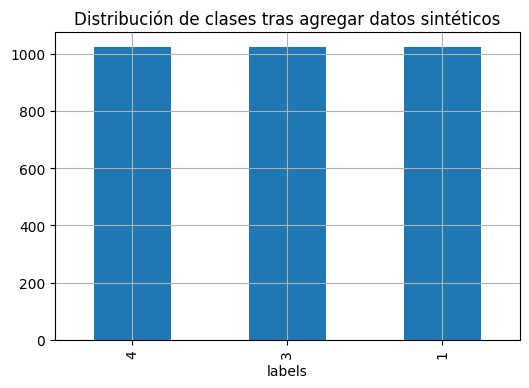

labels
4    1025
3    1025
1    1025
Name: count, dtype: int64

In [33]:
df["labels"].value_counts().plot.bar(title="Distribución de clases tras agregar datos sintéticos");plt.show()
df["labels"].value_counts()

### 2. Normalización y estandarización: 
Limpieza de caracteres, minúsculas, tokenización, eliminación de stopwords en español y stemming.  

In [34]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
spanish_stopwords = stopwords.words("spanish")


wpt = WordPunctTokenizer()
ps = SnowballStemmer("spanish")
spanish_stopwords = set(stopwords.words("spanish"))

def normalize_text(doc):
    # Limpieza de caracteres
    doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)
    doc = doc.lower().strip()
    
    # Tokenización
    tokens = wpt.tokenize(doc)
    
    # Quitar stopwords + stemming
    filtered_tokens = [ps.stem(token) for token in tokens if token not in spanish_stopwords]
    
    return ' '.join(filtered_tokens)

# Aplicar a todo el DataFrame
normalize_data = np.vectorize(normalize_text)
norm_data = normalize_data(df["textos"].astype(str))

def norm_all_data (data):
    normalize_data = np.vectorize(normalize_text)
    norm_data = normalize_data(data.astype(str))
    return norm_data


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yarso\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Las stopwords en español nos permiten eliminar palabras muy comunes (como “de”, “la”, “que”), que no aportan valor a la clasificación. De esta forma el modelo se concentra en términos más relevantes para diferenciar entre los ODS. Esto es coherente con el entendimiento previo, donde identificamos vocabulario repetitivo que podía introducir ruido.

Se aplica normalización (minúsculas, limpieza de caracteres) y stemming, junto con tokenización y eliminación de stopwords. Esto asegura que textos con la misma raíz (e.g. “educar”, “educación”) se procesen como equivalentes, reduciendo variabilidad innecesaria y facilitando que el modelo capture patrones claros.

### 3. Division en test y train
En este caso como no vamos a usar otros modelos aparte de SVM no es necesario ddatos de validación

In [35]:
#Split de datos de entrenamiento y prueba (80%, 20%) 
X = norm_data
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)


### 4. Vectorización TF-IDF
Transformación de textos a representaciones numéricas considerando unigramas y bigramas, con filtros de frecuencia mínima y máxima.

In [36]:
# Vectorización TF-IDF, eso es Term Frequency–Inverse Document Frequency (lo vimos en clase)
# Entonces las palabras que aparecen en muchos documentos (alta frecuencia) tienen menos peso
# y las que aparecen en pocos documentos (baja frecuencia) tienen más peso
# Después de la búsqueda de hiperparámetros en etapa 1, los mejores params: { 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}

tfidf = TfidfVectorizer(
    strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b",   
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)

**En resumen:**
- Se creó un pipeline de normalización que asegura textos homogéneos y enfocados en palabras relevantes (ej. salud, educación, pobreza).  
- Los datos fueron divididos en entrenamiento (80%) y prueba (10%). 
- La vectorización TF-IDF generó un espacio de 13,057 características, capturando unigramas y bigramas, ademas, se filtraron términos muy raros o demasiado frecuentes.  
- Este conjunto procesado está listo para la fase de modelado y evaluación.


## 3. Reentrenamiento del mejor modelo de la etapa 1 : Linear SVM 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejores params: {'svm__C': 1.0, 'svm__class_weight': None, 'svm__loss': 'hinge', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro: 0.98

 SVM (mejor grid) en datos de validación 

              precision    recall  f1-score   support

           1      0.971     0.966     0.968       205
           3      0.980     0.951     0.965       205
           4      0.958     0.990     0.974       205

    accuracy                          0.969       615
   macro avg      0.969     0.969     0.969       615
weighted avg      0.969     0.969     0.969       615



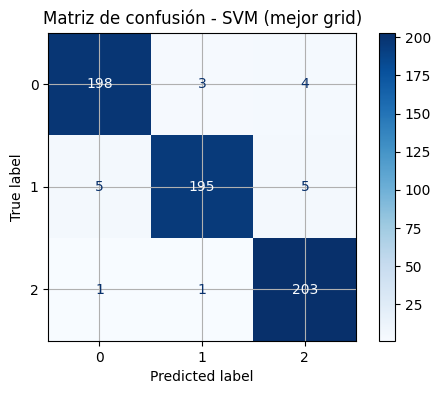

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...001E9D1ADFF60>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [37]:
#Creamos un pipeline para encapsular el proceso de vectorización y el modelo linear SVM
from sklearn.pipeline import FunctionTransformer
from sklearn.svm import LinearSVC
import joblib

pipeSVM = Pipeline([
    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),
    ("svm", LinearSVC())
])

# Definimos el grid de hiperparámetros para SVM
param_grid_svm = {
    "svm__C": [0.1, 1.0, 10.0],
    "svm__loss": ["hinge", "squared_hinge"],
    "svm__class_weight": [None, "balanced"],

    "tfidf__min_df": [2, 3],
    "tfidf__max_df": [0.85, 0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
    
}

# Configuramos el GridSearchCV para SVM
grid_svm = GridSearchCV(pipeSVM, param_grid_svm, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_svm.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe_svm = grid_svm.best_estimator_
print("Mejores params:", grid_svm.best_params_)
print("Mejor F1 macro:", round(grid_svm.best_score_, 2))

# Evaluación en Val, esto no visto por el modelo en ninguna etapa
y_pred = mejor_pipe_svm.predict(X_test)
print("\n SVM (mejor grid) en datos de validación \n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()

joblib.dump(mejor_pipe_svm, "docs/svm_pipeline_etapa2.joblib")
mejor_pipe_svm

El modelo SVM (con Balanceo) muestra un rendimiento muy alto y equilibrado en el conjunto de test. Todas las métricas de precision, recall y F1-score se sitúan alrededor de 0.96–0.97, lo que indica que el modelo no solo acierta la mayoría de las veces, sino que también lo hace de manera consistente entre las tres clases (1, 3 y 4). El hecho de que el macro avg y el weighted avg sean idénticos (0.969) demuestra que las clases están bien balanceadas en el conjunto de test y que el modelo no favorece a ninguna en particular.

La matriz de confusión confirma este comportamiento: la mayoría de las predicciones se encuentran en la diagonal principal, con muy pocos errores de clasificación (solo entre 3 y 5 casos confundidos por clase). Esto significa que el modelo logra distinguir con gran precisión entre las tres categorías, mostrando un desempeño sólido, generalizable y sin sesgos importantes entre clases.

# 4. Validación de los dos modelo SVM con los nuevos datos
- Etapa 1 (sin balanceo de etiquetas): Para esto importamos el pipeline del mejor modelo logrado en la etapa 1, se lo aplicamos a los nuevos datos y verificamos metricas.
- Etapa 2 (con balanceo de etiquetas con IA): Para esto importamos el pipeline del mejor modelo logrado en la etapa 1, se lo aplicamos a los nuevos datos y verificamos metricas.

Pipeline cargado exitosamente.

 SVM (etapa 1 sin balanceo) en nuevos datos de prueba 

              precision    recall  f1-score   support

           1      1.000     0.810     0.895        21
           3      0.875     1.000     0.933        35
           4      0.952     0.930     0.941        43

    accuracy                          0.929        99
   macro avg      0.942     0.913     0.923        99
weighted avg      0.935     0.929     0.929        99



C:\Users\Lila\AppData\Local\Temp\ipykernel_9684\2574022093.py:18: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


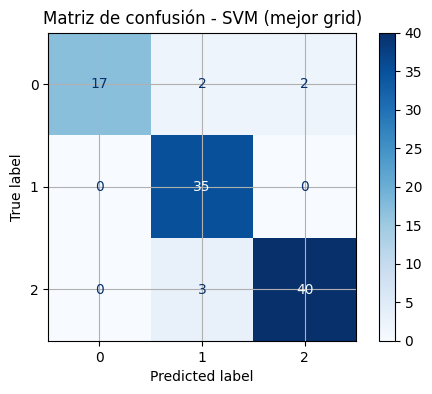

In [36]:
# Validación modelo SVM de la Etapa 1
# Cargar el pipeline de la etapa 1 y predecir en nuevos datos de prueba
pipeline = joblib.load("docs/svm_pipeline.joblib")
print("Pipeline cargado exitosamente.")

X_test = df_validacion["textos"].astype(str)
y_test = df_validacion["labels"]
y_pred = pipeline.predict(X_test)

print("\n SVM (etapa 1 sin balanceo) en nuevos datos de prueba \n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()

Pipeline cargado exitosamente.

 SVM (etapa 2 con balanceo) en nuevos datos de prueba 

              precision    recall  f1-score   support

           1      1.000     0.810     0.895        21
           3      0.897     1.000     0.946        35
           4      0.977     0.977     0.977        43

    accuracy                          0.949        99
   macro avg      0.958     0.929     0.939        99
weighted avg      0.954     0.949     0.948        99



C:\Users\Lila\AppData\Local\Temp\ipykernel_9684\2574022093.py:18: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


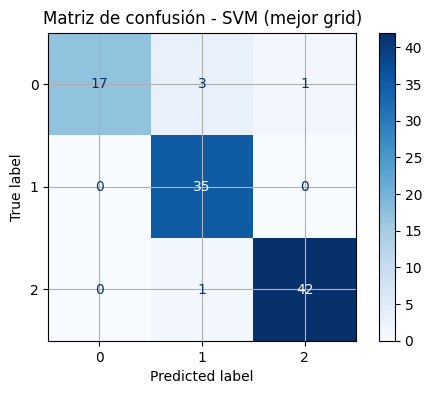

In [ ]:
# Validación modelo SVM de la Etapa 2
# Cargar el pipeline de la etapa 2 y predecir en nuevos datos de prueba
pipeline = joblib.load("docs/svm_pipeline_etapa2.joblib")
print("Pipeline cargado exitosamente.")

X_test = df_validacion["textos"].astype(str)
y_test = df_validacion["labels"]
y_pred = pipeline.predict(X_test)

print("\n SVM (etapa 2 con balanceo) en nuevos datos de prueba \n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()

In [ ]:
df.to_csv("docs/dataset_balanceado_etapa2.csv", index=False)

# Resultados y conclusiones finales tras comparativa

Teniendo en cuenta los resultados anteriores, tenemos esta tabla centralizada:

| Métrica / Clase | SVM Etapa 1 (sin balanceo) | SVM Etapa 2 (con balanceo IA) | Δ% Mejora |
|------------------|-----------------------------|-----------------------------|------------|
| **Clase 1 - F1-score** | 0.895 | 0.895 | 0.00% |
| **Clase 3 - F1-score** | 0.933 | 0.946 | **+1.39%** |
| **Clase 4 - F1-score** | 0.941 | 0.977 | **+3.82%** |
| **Accuracy** | 0.929 | 0.949 | **+2.15%** |
| **Macro avg - F1-score** | 0.923 | 0.939 | **+1.74%** |

Podemos notar que si hay una mejoria en todas las métricas en el modelo de la etapa 2 de balanceo con IA, la metrica que usamos principalmente es macro avg ya que esta pondera las metricas de todas las clases por igual, lo que nos permite verificar si el modelo trata igual de bien todas las clases. Teniendo en cuenta lo anterior, el macro avg del modelo de la etapa 2 aumento casi 2 puntos porcentuales con respecto al modelo de la etapa 1, por lo que podemos decir que **el balanceo de clases con IA si mejora el rendimiento del modelo**.

- Es importante mencionar que para dar conclusiones con más certeza seria necesario que se nos brindara un dataset de validación mas amplio, ya que los datos de validación brindado sólo tienen 99 filas (se necesitan mínimo 200), lo que hace que las metricas sean inestables pues cada predicción correcta o incorrecta cambia mucho el valor de estas. Sin embargo, y teniendo en cuenta las metricas obtenidas del modelo para test, el modelo con balanceo IA muestra un rendimiento muy alto y equilibrado. Todas las métricas de precision, recall y F1-score se sitúan alrededor de 0.96–0.98, lo que indica que el modelo no solo acierta la mayoría de las veces, sino que también lo hace de manera consistente entre las tres clases (1, 3 y 4).